<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Experiments/1d_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -qq neural_tangents==0.2.2

In [2]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
from jax.lib import xla_bridge
import jax.numpy as np
import neural_tangents as nt
from neural_tangents import stax
from jax.example_libraries import optimizers
import jax.numpy as jnp

import os

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from tqdm.notebook import tqdm as tqdm

import time

import numpy as onp

/tmp/ipykernel_3345002/2706731140.py:3: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
2024-01-30 22:49:18.046656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 22:49:18.046719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 22:49:18.047705: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 22:49:18.888103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def sine_activation(w0, x):
    return jnp.sin(w0 * x)


def SineLayer(w0=1.0):
    def init_fun(rng, input_shape):
        return input_shape, ()

    def apply_fun(params, inputs, **kwargs):
        return sine_activation(w0, inputs)

    return init_fun, apply_fun

In [4]:
# Utils

fplot = lambda x: np.fft.fftshift(np.log10(np.abs(np.fft.fft(x))))

# Signal makers


def sample_random_signal(key, decay_vec):
    N = decay_vec.shape[0]
    raw = random.normal(key, [N, 2]) @ np.array([1, 1j])
    signal_f = raw * decay_vec
    signal = np.real(np.fft.ifft(signal_f))
    return signal


def sample_random_powerlaw(key, N, power):
    coords = np.float32(
        np.fft.ifftshift(1 + N // 2 - np.abs(np.fft.fftshift(np.arange(N)) - N // 2))
    )
    decay_vec = coords**-power
    decay_vec = onp.array(decay_vec)
    decay_vec[N // 4 :] = 0
    return sample_random_signal(key, decay_vec)


# Network


def make_network(num_layers, num_channels, ntk_params=True, num_outputs=1):
    layers = []
    for i in range(num_layers - 1):
        if ntk_params:
            layers.append(stax.Dense(num_channels, parameterization="standard"))
        else:
            layers.append(stax.Dense(num_channels, parameterization="standard"))

        if i == 0:
            layers.append(stax.Sin())
        else:
            layers.append(stax.Relu())
    layers.append(stax.Dense(num_outputs, parameterization="standard"))
    return stax.serial(*layers)


# Encoding


def compute_ntk(x, avals, bvals, kernel_fn):
    x1_enc = input_encoder(x, avals, bvals)
    x2_enc = input_encoder(np.array([0.0], dtype=np.float32), avals, bvals)
    out = np.squeeze(kernel_fn(x1_enc, x2_enc, "ntk"))
    return out


input_encoder = lambda x, a, b: np.concatenate(
    [
        a * np.sin((2.0 * np.pi * x[..., None]) * b),
        a * np.cos((2.0 * np.pi * x[..., None]) * b),
    ],
    axis=-1,
) / np.linalg.norm(a)


def predict_psnr_basic(
    kernel_fn, train_fx, test_fx, train_x, train_y, test_x, test_y, t_final, eta=None
):
    g_dd = kernel_fn(train_x, train_x, "ntk")
    g_td = kernel_fn(test_x, train_x, "ntk")
    train_predict_fn = nt.predict.gradient_descent_mse(g_dd, train_y[..., None])
    train_theory_y, test_theory_y = train_predict_fn(
        t=t_final,
        fx_train_0=train_fx[..., None],
        fx_test_0=test_fx[..., None],
        k_test_train=g_td,  # NOTE: check whether this is correct?????
    )

    calc_psnr = lambda f, g: -10.0 * np.log10(np.mean((f - g) ** 2))
    return calc_psnr(test_y, test_theory_y[:, 0]), calc_psnr(
        train_y, train_theory_y[:, 0]
    )


predict_psnr_basic = jit(predict_psnr_basic, static_argnums=(0,))


def train_model(
    rand_key,
    network_size,
    lr,
    iters,
    train_input,
    test_input,
    test_mask,
    optimizer,
    ab,
    name="",
):
    if ab is None:
        ntk_params = False
    else:
        ntk_params = True
    init_fn, apply_fn, kernel_fn = make_network(*network_size, ntk_params=ntk_params)

    if ab is None:
        run_model = jit(
            lambda params, ab, x: np.squeeze(apply_fn(params, x[..., None] - 0.5))
        )
    else:
        run_model = jit(
            lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab)))
        )
    model_loss = jit(
        lambda params, ab, x, y: 0.5 * np.sum((run_model(params, ab, x) - y) ** 2)
    )
    model_psnr = jit(
        lambda params, ab, x, y: -10
        * np.log10(np.mean((run_model(params, ab, x) - y) ** 2))
    )
    model_grad_loss = jit(
        lambda params, ab, x, y: jax.grad(model_loss)(params, ab, x, y)
    )

    opt_init, opt_update, get_params = optimizer(lr)
    opt_update = jit(opt_update)

    if ab is None:
        _, params = init_fn(rand_key, (-1, 1))
    else:
        _, params = init_fn(
            rand_key, (-1, input_encoder(train_input[0], *ab).shape[-1])
        )
    opt_state = opt_init(params)

    pred0 = run_model(get_params(opt_state), ab, test_input[0])
    pred0_f = np.fft.fft(pred0)

    train_psnrs = []
    test_psnrs = []
    theories = []
    xs = []
    errs = []
    for i in tqdm(range(iters), desc=name):
        opt_state = opt_update(
            i, model_grad_loss(get_params(opt_state), ab, *train_input), opt_state
        )

        if i % 20 == 0:
            train_psnr = model_psnr(get_params(opt_state), ab, *train_input)
            test_psnr = model_psnr(
                get_params(opt_state),
                ab,
                test_input[0][test_mask],
                test_input[1][test_mask],
            )
            if ab is None:
                train_fx = run_model(get_params(opt_state), ab, train_input[0])
                test_fx = run_model(get_params(opt_state), ab, test_input[0][test_mask])
                theory = predict_psnr_basic(
                    kernel_fn,
                    train_fx,
                    test_fx,
                    train_input[0][..., None] - 0.5,
                    train_input[1],
                    test_input[0][test_mask][..., None],
                    test_input[1][test_mask],
                    i * lr,
                )
            else:
                test_x = input_encoder(test_input[0][test_mask], *ab)
                train_x = input_encoder(train_input[0], *ab)

                train_fx = run_model(get_params(opt_state), ab, train_input[0])
                test_fx = run_model(get_params(opt_state), ab, test_input[0][test_mask])
                theory = predict_psnr_basic(
                    kernel_fn,
                    train_fx,
                    test_fx,
                    train_x,
                    train_input[1],
                    test_x,
                    test_input[1][test_mask],
                    i * lr,
                )

            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            theories.append(theory)
            pred = run_model(get_params(opt_state), ab, train_input[0])
            errs.append(pred - train_input[1])
            xs.append(i)
    return get_params(opt_state), train_psnrs, test_psnrs, errs, np.array(theories), xs

# Training

In [5]:
N_train = 32
data_power = 1

network_size = (4, 1024)

learning_rate = 1e-5
sgd_iters = 50001

In [6]:
rand_key = random.PRNGKey(0)

config.update("jax_disable_jit", False)

# Signal
M = 8
N = N_train
x_test = np.float32(np.linspace(0, 1.0, N * M, endpoint=False))
x_train = x_test[::M]

test_mask = onp.ones(len(x_test), onp.bool_)
test_mask[np.arange(0, x_test.shape[0], M)] = 0

s = sample_random_powerlaw(rand_key, N * M, data_power)
s = (s - s.min()) / (s.max() - s.min()) - 0.5

# Kernels
bvals = np.float32(np.arange(1, N // 2 + 1))
ab_dict = {}
# ab_dict = {r'$p = {}$'.format(p) : (bvals**-np.float32(p), bvals) for p in [0, 1]}
ab_dict = {
    r"$p = {}$".format(p): (bvals ** -np.float32(p), bvals) for p in [0, 0.5, 1, 1.5, 2]
}
ab_dict[r"$p = \infty$"] = (np.eye(bvals.shape[0])[0], bvals)
ab_dict["No mapping"] = None


# Train the networks

rand_key, *ensemble_key = random.split(rand_key, 1 + len(ab_dict))

outputs = {
    k: train_model(
        key,
        network_size,
        learning_rate,
        sgd_iters,
        (x_train, s[::M]),
        (x_test, s),
        test_mask,
        optimizer=optimizers.sgd,
        ab=ab_dict[k],
        name=k,
    )
    for k, key in zip(ab_dict, ensemble_key)
}

ab_dict.update(
    {r"$p = {}$".format(p): (bvals ** -np.float32(p), bvals) for p in [0.5, 1.5, 2]}
)

$p = 0$:   0%|          | 0/50001 [00:00<?, ?it/s]

$p = 0.5$:   0%|          | 0/50001 [00:00<?, ?it/s]

$p = 1$:   0%|          | 0/50001 [00:00<?, ?it/s]

$p = 1.5$:   0%|          | 0/50001 [00:00<?, ?it/s]

$p = 2$:   0%|          | 0/50001 [00:00<?, ?it/s]

$p = \infty$:   0%|          | 0/50001 [00:00<?, ?it/s]

No mapping:   0%|          | 0/50001 [00:00<?, ?it/s]

# Our proposed SPE

/tmp/ipykernel_3345002/289962847.py:64: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0, 0])
/tmp/ipykernel_3345002/289962847.py:107: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0, 1])


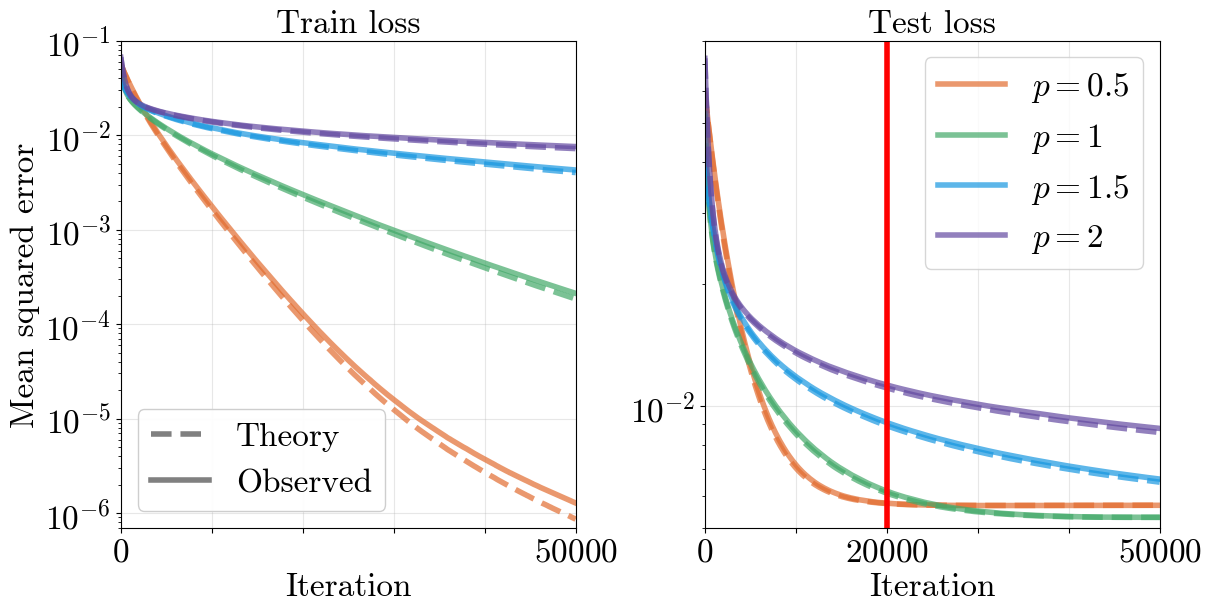

In [18]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

params = {
    "legend.fontsize": 24,
    "axes.labelsize": 24,
    "axes.titlesize": 24,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
}
pylab.rcParams.update(params)


matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["mathtext.rm"] = "serif"

plt.rcParams["font.family"] = "cmr10"

names = list(outputs.keys())
names = [n for n in names if "opt" not in n]
names = [
    # "$p = 0$",
    "$p = 0.5$",
    "$p = 1$",
    "$p = 1.5$",
    "$p = 2$",
    # "$p = \\infty$",
    # "No mapping",
]

N_kernels = len(names)
colors_k = [
    [0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795],
]
linewidth = 4
line_alpha = 0.7
title_offset = -0.2

xs = outputs[names[0]][-1]
t_final = learning_rate * sgd_iters

_, apply_fn, kernel_fn = make_network(*network_size)
_, apply_fn_standard, kernel_fn_standard = make_network(*network_size, ntk_params=False)
run_model = jit(
    lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab)))
)

fig3 = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig3.add_gridspec(1, 2)

H_rows = {
    k: compute_ntk(x_train, *ab_dict[k], kernel_fn)
    for k in names
    if k not in "No mapping"
}

xvals = xs

ax = fig3.add_subplot(gs[0, 0])
for c, k in zip(colors_k, names):
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][1]) / -10),
        color=c,
        label=k,
        alpha=line_alpha,
        linewidth=linewidth,
    )
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][4][:, 1]) / -10),
        "--",
        color=c,
        alpha=line_alpha,
        linewidth=linewidth,
    )

plt.autoscale(enable=True, axis="x", tight=True)
ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
ax.set_xticklabels(["$0$", "", "", "", "", "$50000$"])
# plt.xlabel("Iteration", labelpad=-13)
plt.ylabel("Mean squared error")
plt.xlabel("Iteration")
ax.set_title("Train loss")
ax.set_ylim(top=0.1)
plt.grid(True, which="major", alpha=0.3)

custom_lines = [
    Line2D([], [], color="gray", linestyle="--", linewidth=linewidth),
    Line2D([], [], color="gray", linestyle="-", linewidth=linewidth),
]
ax.legend(
    custom_lines,
    ["Theory", "Observed"],
    loc="lower left",
    ncol=1,
    framealpha=0.95,
    handlelength=1.75,
)
ax.set_ylim(7e-7, 1e-1)

ax = fig3.add_subplot(gs[0, 1])
for c, k in zip(colors_k, names):
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][2]) / -10),
        color=c,
        label=k,
        alpha=line_alpha,
        linewidth=linewidth,
    )
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][4][:, 0]) / -10),
        "--",
        color=c,
        alpha=line_alpha,
        linewidth=linewidth,
    )
ax.vlines(x=20000, ymin=0, ymax=1, colors="red", linewidth=linewidth)
ax.legend()

plt.autoscale(enable=True, axis="x", tight=True)
ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
ax.set_xticklabels(["$0$", "", "$20000$", "", "", "$50000$"])
# plt.xlabel("Iteration", labelpad=-13)
# plt.ylabel("Mean squared error")
plt.xlabel("Iteration")
ax.set_title("Test loss")
ax.set_ylim(5e-3, 8e-2)
# ax.set_yticklabels([], minor=True)
plt.grid(True, which="major", alpha=0.3)

plt.savefig("1d_loss_ours.pdf", bbox_inches="tight")
plt.show()

In [11]:
x_test[i0:i1]
s[i0:i1]

Array([ 0.25632936,  0.24866718,  0.2420913 ,  0.23002666,  0.2053526 ,
        0.18085158,  0.15901607,  0.12591064,  0.08704019,  0.06519461,
        0.05303723,  0.0156644 , -0.04613027, -0.08489358, -0.07941821,
       -0.0698624 , -0.09067458, -0.11439583, -0.10451597, -0.0881474 ,
       -0.11992842, -0.18735549, -0.2112892 , -0.15478185, -0.08524415,
       -0.09254822, -0.16682923, -0.20249909, -0.13101056, -0.01172525,
        0.0374282 , -0.02464387, -0.13614473, -0.22929427, -0.30038804,
       -0.3730452 , -0.44289947, -0.48816624, -0.5       , -0.4767854 ,
       -0.42363942, -0.38012516, -0.4000531 , -0.4680751 , -0.48967084,
       -0.41495088, -0.31817758, -0.28769433, -0.29321468, -0.255085  ,
       -0.19846725, -0.21580356, -0.29293466, -0.310224  , -0.23548222,
       -0.1796101 , -0.21204245, -0.25119865, -0.2165387 , -0.17303675,
       -0.2174331 , -0.30970833, -0.33978432, -0.30256778], dtype=float32)

In [12]:
x_test[i0:i1].shape, s[i0:i1].shape

((64,), (64,))

/tmp/ipykernel_3345002/611274453.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(


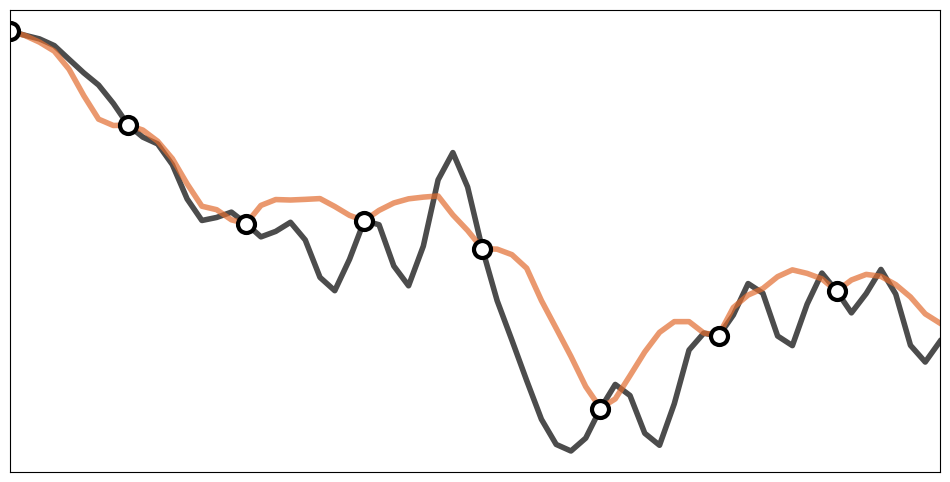

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(
    x_test[i0:i1],
    s[i0:i1],
    label="Target signal",
    color="k",
    linewidth=linewidth,
    alpha=line_alpha,
    zorder=1,
)
plt.autoscale(enable=True, axis="x", tight=True)

plt.scatter(
    x_train[i0 // M : i1 // M],
    s[i0:i1:M],
    color="w",
    edgecolors="k",
    # linewidths=2,
    s=150,
    linewidth=3,
    label="Training points",
    zorder=2,
)


k = "$p = 0$"

c = colors_k[0]
params = outputs[k][0]
plt.plot(
    x_test[i0:i1],
    run_model(params, ab_dict[k], x_test)[i0:i1],
    label=k,
    color=c,
    linewidth=linewidth,
    alpha=line_alpha,
    zorder=1,
)

plt.xticks([])
plt.yticks([])
plt.show()

In [14]:
# save targets

np.save("./1d_regression_results/target/line_x.npy", x_test[i0:i1])
np.save("./1d_regression_results/target/line_y.npy", s[i0:i1])
np.save("./1d_regression_results/target/scatter_x.npy", x_train[i0 // M : i1 // M])
np.save("./1d_regression_results/target/scatter_y.npy", s[i0:i1:M])

In [15]:
# save ours

k = "$p = 0$"
np.save("./1d_regression_results/ours/line_x.npy", x_test[i0:i1])
np.save("./1d_regression_results/ours/line_y.npy", run_model(params, ab_dict[k], x_test)[i0:i1])